# Melanoma Detection with Standard CNN Model (for baseline comparison) 

This code was used with Googles Compute Engine backend (GPU), containing roughly 40GB of vRAM. Google Drive was mounted to read/write files via drive.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle
import albumentations as T
import cv2 

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb  8 21:53:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    20W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Variables to Modify

In [3]:
# best combo -> seed = 42, batch_size = 42, crop_size = 384, model_id = 200

# cropped size input
crop_size = 512 # 512, 384

# random seed
seed = 42 

# set our batch size
batch_size = 20

# if currently validating
validating = False

# if loading weights or creating weights
load_weights = False
create_new_weights = True

# path to store intermediate weights
PATH = 'drive/MyDrive/MAS/Melanoma_CNN_Ensemble.pth'

## Mount Google Drive, download compressed data locally, then unzip the Data.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cp -av drive/MyDrive/MAS/train_data512x512.zip .
!unzip train_data512x512.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_data512x512/jpgs/ISIC_6961482.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_6961482.jpg  
  inflating: train_data512x512/jpgs/ISIC_0528791.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_0528791.jpg  
  inflating: train_data512x512/jpgs/ISIC_6900068.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_6900068.jpg  
  inflating: train_data512x512/jpgs/ISIC_5611010.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_5611010.jpg  
  inflating: train_data512x512/jpgs/ISIC_2776986.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_2776986.jpg  
  inflating: train_data512x512/jpgs/ISIC_1860049.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_1860049.jpg  
  inflating: train_data512x512/jpgs/ISIC_8214363.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._ISIC_8214363.jpg  
  inflating: train_data512x512/jpgs/ISIC_3632547.jpg  
  inflating: __MACOSX/train_data512x512/jpgs/._

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.01762965646320111


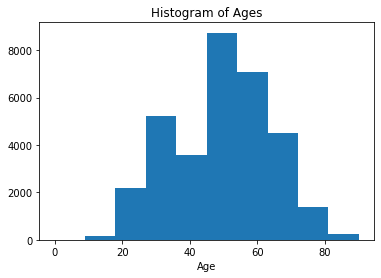

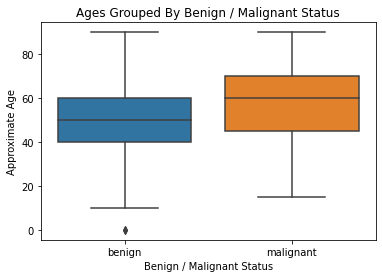

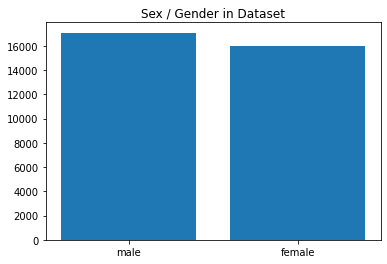

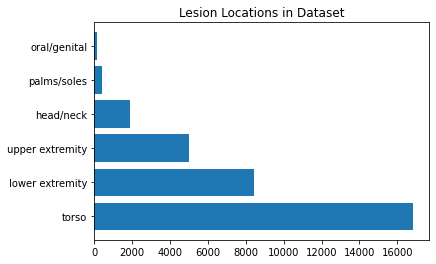

In [5]:
mel_df = pd.read_csv(os.path.join(f'train_data{crop_size}x{crop_size}', 'meta.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             15761        220
male               16716        364
Chi-Squared test of independence (P-value): 2.4342390352678135e-07 



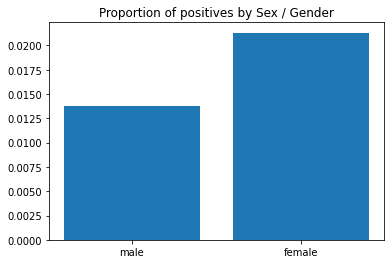



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               834             4449            45   
male                                1013             3950            79   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 151   7580             2687  
male                                   224   9246             2276  
Chi-Squared test of independence (P-value): 4.565901797450338e-49 



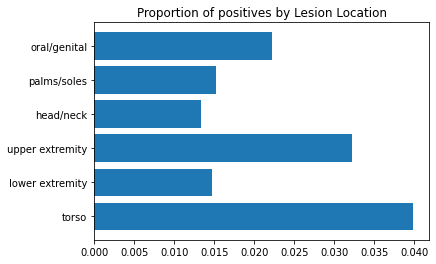

In [6]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## CNN Development

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 1


In [8]:
mel_df = pd.read_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "meta.csv"))
print(mel_df.shape)
mel_df = pd.get_dummies(mel_df[["sex", "age_approx", "anatom_site_general_challenge"]], drop_first=True)
mel_df['age_approx'].fillna(value=mel_df['age_approx'].mean(), inplace=True)
mel_df.fillna(0)

(33126, 11)


,age_approx,sex_male,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,45.0,1,0,0,0,0,0
1,45.0,0,0,0,0,0,1
2,50.0,0,1,0,0,0,0
3,45.0,0,0,0,0,0,0
4,55.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
33121,50.0,1,0,0,0,1,0
33122,65.0,1,0,0,0,1,0
33123,20.0,1,1,0,0,0,0
33124,50.0,1,1,0,0,0,0


# Train-Test Split

In [9]:
np.random.seed(seed) # for reproducability

meta_df = pd.read_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "meta.csv"))
ind = np.arange(len(meta_df))

meta_df[:int(0.80*len(meta_df))].to_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "train.csv"), index=False)
meta_df[int(0.80*len(meta_df)):].to_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "test.csv"), index=False)

If still in validation stage, re-split the training set to obtain a validation set for tuning things like the hyper-parameters and the number of epochs. Otherwise, train with the entire training set.

In [10]:
if validating:
    orig_train_df = pd.read_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "train.csv"))

    meta_df[:int(0.8*len(orig_train_df))].to_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "train.csv"), index=False)
    meta_df[int(0.8*len(orig_train_df)):].to_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "val.csv"), index=False)

Examine training, validation, or testing set

In [11]:
mel_df = pd.read_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "train.csv"))
num_negs = len(mel_df[mel_df['target']==0])
print(mel_df.shape)
mel_df = pd.get_dummies(mel_df[["sex", "age_approx", "anatom_site_general_challenge"]], drop_first=True)
mel_df['age_approx'].fillna(value=mel_df['age_approx'].mean(), inplace=True)
mel_df.fillna(0)

(26500, 11)


,age_approx,sex_male,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,45.0,1,0,0,0,0,0
1,45.0,0,0,0,0,0,1
2,50.0,0,1,0,0,0,0
3,45.0,0,0,0,0,0,0
4,55.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
26495,50.0,1,0,0,0,0,0
26496,35.0,0,0,0,0,1,0
26497,30.0,1,0,0,0,1,0
26498,50.0,0,1,0,0,0,0


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [12]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile)
        
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
        
        ####### encode categorical data for csv inputs
        self.mel_df = pd.get_dummies(mel_df[["sex", "age_approx", "anatom_site_general_challenge"]], drop_first=True)
        self.mel_df['age_approx'].fillna(value=mel_df['age_approx'].mean(), inplace=True)
        self.mel_df.fillna(0)

        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = cv2.imread(img_path)
  
        if self.transform:
            img = self.transform(image=img)['image'].astype(np.float32)

        img = img.transpose(2, 0, 1)
        img = torch.tensor(img).float()

        class_id = torch.tensor([self.gt[idx]])
        
        csvData = np.array(self.mel_df.iloc[idx].values, dtype=np.float32)
        csvData = torch.from_numpy(csvData)
    
        
        return (img, csvData), class_id


In [13]:
def pad_collate2d(batch):
    
    # init lists
    image_list, csv_list, label_list = [], [], []
   
    for (_image, _csvData), _label in batch:
        image_list.append(torch.unsqueeze(_image, dim=0))
        csv_list.append(torch.unsqueeze(_csvData, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    csv_out = torch.cat(csv_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return (image_out, csv_out), label_out


In [14]:
testing_loader = False


# batches per epoch
bpe = (2 * num_negs) / batch_size

# number of rows in test set
num_test_obs = len(meta_df) - len(mel_df)

# create pre-processing transforms 
tr_transf = T.Compose(
    [T.HueSaturationValue(sat_shift_limit=[0.9, 1.1], hue_shift_limit=[-0.1, 0.1]),
     T.VerticalFlip(p=0.5),
     T.HorizontalFlip(p=0.5),
     T.ShiftScaleRotate(rotate_limit=90, scale_limit = [0.7, 1.3]),
     T.RandomBrightnessContrast(brightness_limit=[0.9, 1.1], contrast_limit= [0.9, 1.1]),
     T.Normalize()
    ])

val_transf = T.Compose(
    [T.Normalize()
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join(f'train_data{crop_size}x{crop_size}', "jpgs"), 
                            patientfile=os.path.join(f'train_data{crop_size}x{crop_size}', "train.csv"), 
                            num_samples=10*2*num_negs, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)

if validating:
    val_dataset = ISICDatasetImages(img_dir=os.path.join(f'train_data{crop_size}x{crop_size}', "jpgs"), 
                                patientfile=os.path.join(f'train_data{crop_size}x{crop_size}', "val.csv"), 
                                num_samples=num_test_obs, up_sample=False, start_ind=0, transform=val_transf)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                            num_workers=n_workers)



# test DataLoader with custom settings
if testing_loader:
    for (image, csvData), labels in train_loader:
        print('Data shape:', image.shape, '|', csvData.shape)
        print('Batch of labels:', labels, '\n')
        break
        
    for (image, csvData), labels in val_loader:
        print('Data shape:', image.shape, '|', csvData.shape)
        print('Batch of labels:', labels, '\n')
        break
    


In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # CNN (feature extraction)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 6, 7) # 512 to 253
        self.conv2 = nn.Conv2d(6, 15, 7)  # to 124
        self.conv2_bn = nn.BatchNorm2d(15) 
        self.conv3 = nn.Conv2d(15, 30, 7)  # to 59
        self.conv3_bn = nn.BatchNorm2d(30)
        self.conv4 = nn.Conv2d(30, 60, 5)  # to 26
        self.conv4_bn = nn.BatchNorm2d(60)
        self.conv5 = nn.Conv2d(60, 80, 5)   # to 11
        self.conv5_bn = nn.BatchNorm2d(80)
        self.conv6 = nn.Conv2d(80, 100, 5)  # to  3
        self.conv6_bn = nn.BatchNorm2d(100)
        self.fc1 = nn.Linear(100*3*3, 512) 
        self.fc2 = nn.Linear(512, 512)


        # MLP (meta data network)
        self.mlp = nn.Sequential(nn.Linear(7, 256),
                                 nn.BatchNorm1d(256),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        self.final_classification = nn.Sequential(nn.Linear(512 + 256, 1),
                                                  nn.Sigmoid())
        

        
    def forward(self, image, csvData):

            
        # cnn

        x = self.pool(F.relu(self.conv1(image)))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        x = self.pool(F.relu(self.conv6_bn(self.conv6(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        im_out = F.relu(self.fc2(x))
        
        
        # mlp
        mlp_out = self.mlp(csvData)
            
        # concatenate two image and CSV data
        im_and_mlp_out = torch.cat((im_out, mlp_out), dim=1)
        
        # classification stage 
        out = self.final_classification(im_and_mlp_out)
        
        return out
        

In [17]:
!pip install git+https://github.com/facebookresearch/fvcore.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-zpcxvpio
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-zpcxvpio
  Resolved https://github.com/facebookresearch/fvcore.git to commit 6bde555d2b594c45e99742128217f07e414201bd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65379 sha256=33d99c7dfc4b22b733dc0ed00b9e8dae89700ed3dd19b5733083d85772e86c5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-yy4v4jxo/wheels/1c/a9/3c/ff2edce1a1295c72dfff759833097cb1d7713d2f09672d4dd1
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=eab43a296a93a177aabe44e4c82d7a13e606ffd5ad27e5e81a

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [18]:
if load_weights:
    print('Loading the pre-trained CNN Ensemble weights.')
    
    net = Net()
    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    
    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=bpe, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new CNN Ensemble Layer weights.')
        
    net = Net()
    net.to(device)
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=0.01)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=bpe, gamma=0.5)
    
    

Creating new CNN Ensemble Layer weights.


In [ ]:
learn_weights = True

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        (images, csvData), labels = data
        images, csvData, labels = images.to(device), csvData.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(images, csvData)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = int(mini_batch // bpe)

        # print every 50 mini-batch
        if i % 50 == 0:
            print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
            print(f'[Epoch {epoch}, Batch {int(mini_batch % bpe)}] Loss: {running_loss / (i+1)}\n')

        # save and outoput every 500 mini-batch
        if i % 500 == 0:

            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
        # eval every 500 mini-batch
        if i % 500 == 0 and validating:
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []
            validation_loss = 0

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    
                    (image, csvData), label = valdata
                    image, csvData, label = image.to(device), csvData.to(device), label.to("cpu")
                
                    
                    # calculate outputs by running images through the network 
                    outputs = net(image, csvData)

                    # everything saved should be on RAM
                    outputs = outputs.to("cpu")

                    loss = criterion(outputs, label.unsqueeze(-1).float())
                    validation_loss += loss.item()

                    # save for analysis
                    if label.size() > torch.Size([1]):
                        ground_truths += label.squeeze(-1).tolist()
                    else:
                        ground_truths.append(label.squeeze(-1).tolist())
                        

                    # # save for analysis
                    probs += outputs.squeeze(-1).tolist()
                    

            print(f"Validation ROC AUC:", metrics.roc_auc_score(ground_truths, probs))
            print(f'Validation Loss: {validation_loss / (j+1)}')

            if metrics.roc_auc_score(ground_truths, probs) > 0.9:

                print("\n\n\t FOUND AUC OVER 0.90 -- SAVINGS WEIGHTS \n")

                tPATH = f'drive/MyDrive/MAS/Melanoma_CNN_Ensemble_Over90AUC.pth'
                # save the weights and optimizer
                torch.save({'mini_batch': mini_batch,
                            'model_state_dict': net.state_dict(), 
                            'optimizer_state_dict': optimizer.state_dict(),
                            'lr_sched': lr_sched.state_dict()}, tPATH)

            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")


    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


# Formally test performance on our test set

First, we set up our test data loader.

In [19]:
test_dataset = ISICDatasetImages(img_dir=os.path.join(f'train_data{crop_size}x{crop_size}', "jpgs"), 
                            patientfile=os.path.join(f'train_data{crop_size}x{crop_size}', "test.csv"), 
                            num_samples=num_test_obs, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)


Next, we show a few examples of benign skin images compared to a few examples of malignant images.

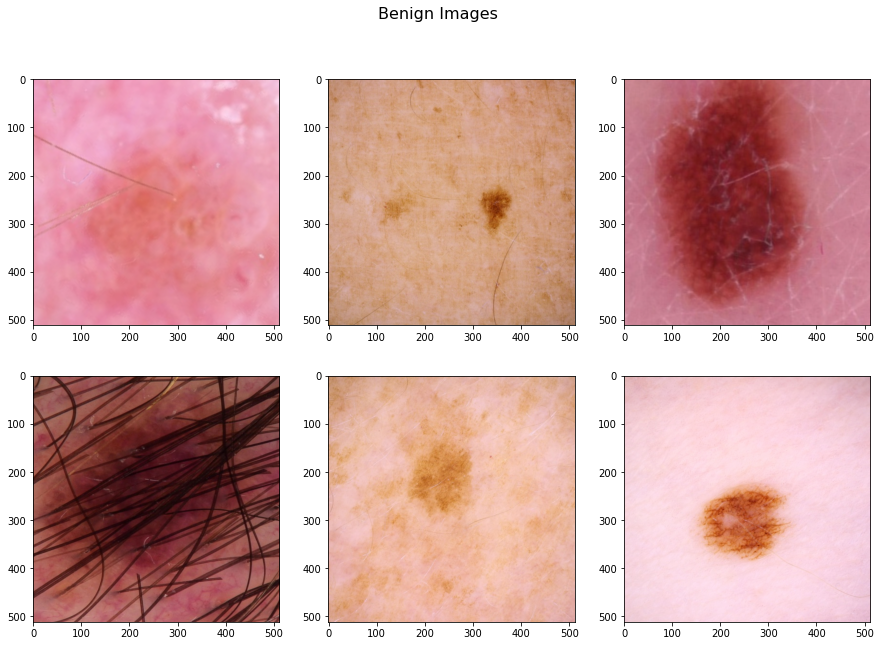

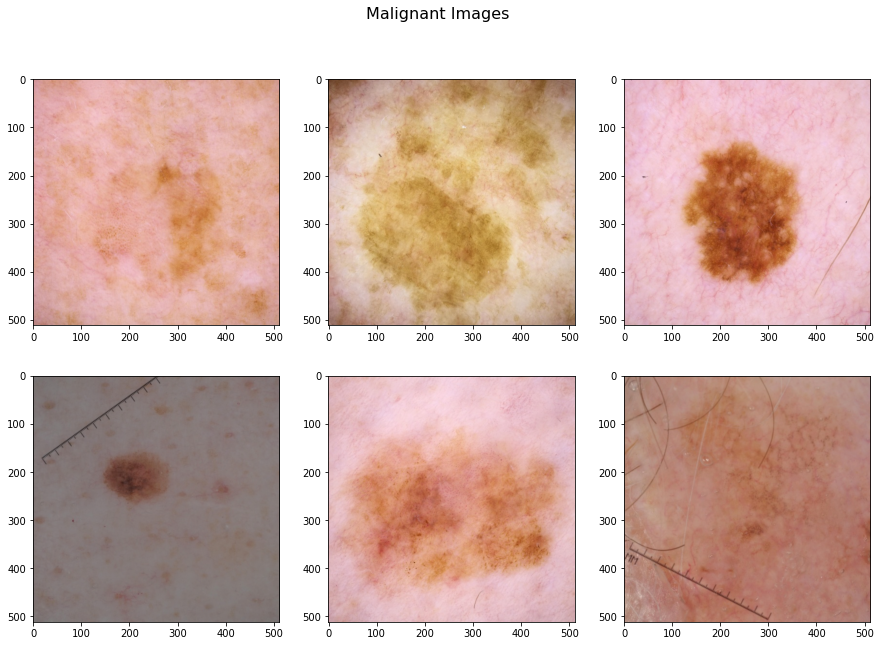

In [20]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = 255*(img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))


test_df = pd.read_csv(os.path.join(f'train_data{crop_size}x{crop_size}', "train.csv"))

tr_transf = T.Compose(
    [T.HueSaturationValue(sat_shift_limit=[0.9, 1.1], hue_shift_limit=[-0.1, 0.1]),
     T.VerticalFlip(p=0.5),
     T.HorizontalFlip(p=0.5),
     T.ShiftScaleRotate(rotate_limit=90, scale_limit = [0.7, 1.3]),
     #T.RandomBrightnessContrast(brightness_limit=[0.9, 1.1], contrast_limit= [0.7, 1.1]),
     T.Normalize()
    ])

benign_id = test_df[test_df.target == 0]['image_name']

plt.figure(figsize=(15,10))
for i in range(6):
    plt.suptitle('Benign Images', fontsize = 16)
    plt.subplot(2, 3, i + 1)

    img_path = os.path.join(f'train_data{crop_size}x{crop_size}', "jpgs",f"{benign_id.iloc[i]}.jpg")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = tr_transf(image=img)['image'].astype(np.float32)

    img = img.transpose(2, 0, 1)
    img = torch.tensor(img).float()
    imshow(img)

plt.show()


mal_id = test_df[test_df.target == 1]['image_name']

plt.figure(figsize=(15,10))
for i in range(6):
    plt.suptitle('Malignant Images', fontsize = 16)
    plt.subplot(2, 3, i + 1)

    img_path = os.path.join(f'train_data{crop_size}x{crop_size}', "jpgs", f"{mal_id.iloc[i]}.jpg")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = val_transf(image=img)['image'].astype(np.float32)

    img = img.transpose(2, 0, 1)
    img = torch.tensor(img).float()
    imshow(img)

plt.show()



Fortunately, we saved the optimally trained weights, so we load those in, create predictions, and save those predictions incase we don't have the resources to compute them next time.

In [22]:
OPT_MODEL_PATH = f'drive/MyDrive/MAS/Melanoma_CNN_Ensemble.pth'


print(f'Loading: {OPT_MODEL_PATH}\n')
    
net = Net()
checkpoint = torch.load(OPT_MODEL_PATH, map_location=device)
net.load_state_dict(checkpoint['model_state_dict'])
net.to(device)

net.load_state_dict(checkpoint['model_state_dict'])  
criterion = nn.BCELoss()

net.eval()

# set start time for cnn training
start_time = time.time()

ground_truths = []
probs = []

running_loss = 0.0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, testdata in enumerate(test_loader, 0):

        (image, csvData), label = testdata
        image, csvData, label = image.to(device), csvData.to(device), label.to(device)


        # calculate outputs by running images through the network 
        outputs = net(image, csvData)
        
        loss = criterion(outputs, label.unsqueeze(-1).float())
        running_loss += loss.item()
    
        # everything saved should be on RAM
        outputs = outputs.to("cpu")
        label = label.to("cpu")
        
        # save for analysis
        ground_truths.append(label)
        
        # # save for analysis
        probs += outputs.squeeze(-1).tolist()

        if i % 10 == 0:
            print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
            print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

            
print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

            
# Save ground-truths and probability results¶
res = {}
res["ground_truths"] = ground_truths
res["probs"] = probs
res["num_batches"] = checkpoint['mini_batch']
res["testing_loss"] = running_loss / (i+1)

pkl_f_name = f'drive/MyDrive/MAS/CNN_Ensemble_Preds.pkl'
with open(pkl_f_name, 'wb') as f:
    pickle.dump(res, f)


Loading: drive/MyDrive/MAS/Melanoma_CNN_Ensemble.pth

	 Processing Batch #0 ... Running Time 7.621867418289185
	 Current Testing Loss: 0.6019261479377747

	 Processing Batch #10 ... Running Time 9.95515775680542
	 Current Testing Loss: 0.5135586668144573

	 Processing Batch #20 ... Running Time 12.922463417053223
	 Current Testing Loss: 0.5218861202398936

	 Processing Batch #30 ... Running Time 17.56088137626648
	 Current Testing Loss: 0.5183228811910076

	 Processing Batch #40 ... Running Time 20.221410274505615
	 Current Testing Loss: 0.5146020251076396

	 Processing Batch #50 ... Running Time 22.809558391571045
	 Current Testing Loss: 0.5105735975153306

	 Processing Batch #60 ... Running Time 25.37943744659424
	 Current Testing Loss: 0.5108148455619812

	 Processing Batch #70 ... Running Time 28.906036138534546
	 Current Testing Loss: 0.5114130272831715

	 Processing Batch #80 ... Running Time 32.12809467315674
	 Current Testing Loss: 0.5111925881585957

	 Processing Batch #90 ...

## Load the pickled predictions (if you must).

In [23]:

with open(f'drive/MyDrive/MAS/CNN_Ensemble_Preds.pkl', 'rb') as f:
    res = pickle.load(f)
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, but forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Generate Comprehensive Results

Max F2-Score is: 0.2727272727272727
Max G-Mean is: 0.7856743283186023
Max Cohen's Kappa is: 0.1771086623179865
Area Under the ROC Curve: 0.8517857720160352 



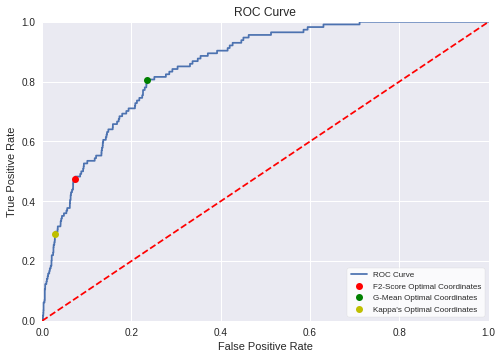


********************* USING F2-SCORE OPTIMAL THRESHOLD *************************
The confusion matrix is:
 [[6032  480]
 [  60   54]] 

Recall / Sensitivity: 0.47368421052631576
Precision: 0.10112359550561797
Specificity: 0.9262899262899262
F2-Score: 0.2727272727272727
G-Mean: 0.662396340911635
Cohen's Kappa: 0.14234678908582588
********************************************************************************


********************** USING G-MEAN OPTIMAL THRESHOLD **************************
The confusion matrix is:
 [[4981 1531]
 [  23   91]] 

Recall / Sensitivity: 0.8070175438596491
Precision: 0.056103575832305796
Specificity: 0.7648955773955773
F2-Score: 0.21896053897978826
G-Mean: 0.7856743283186023
Cohen's Kappa: 0.075103027777079
********************************************************************************


********************** USING KAPPA OPTIMAL THRESHOLD ***************************
The confusion matrix is:
 [[6322  190]
 [  81   33]] 

Recall / Sensitivity: 0.28947368421

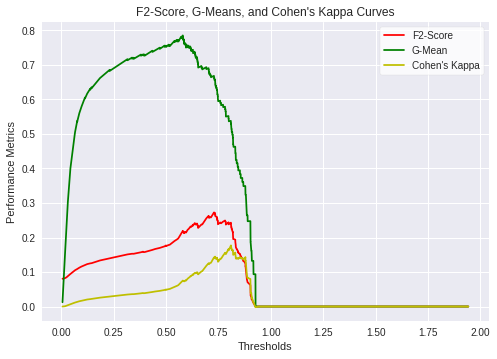

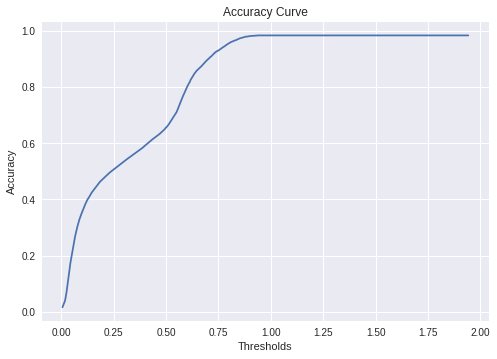

In [24]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()